<a href="https://colab.research.google.com/github/FaragoFa/PDI/blob/main/PDI_Practica_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ACTIVIDAD PRACTICA 7

# Faragó Facundo - 114462

# Cargar repositorio

In [34]:
! git clone https://github.com/FaragoFa/PDI.git

fatal: destination path 'PDI' already exists and is not an empty directory.


# Importar librerias e Imagenes

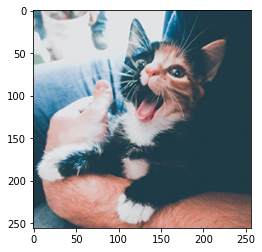

In [35]:
import imageio      #Para leer y guardar imagenes.
import numpy as np  #Operaciones con vectores, matrices, tensores...
import matplotlib.pyplot as plt    #Para realizar graficos.
import matplotlib.image as plti    #Para guardar imagenes.
from scipy.signal import convolve2d #Función para hacer la convolución
from skimage.feature import canny

%matplotlib inline

#Cargo imagen
img = imageio.imread('/content/PDI/Tizona256.jpg')/255
plt.imshow(img)

# Funciónes

## Histograma

In [36]:
def plot_hist(im, bins, ax, cumulative=False):
    counts, borders = np.histogram(im if im.ndim==2 else rgb2yiq(im)[...,0], bins=bins, range=(0,1))
    ax.bar(range(len(counts)), np.cumsum(counts) if cumulative else counts)
    plt.xticks(ax.get_xticks(), labels=np.round(ax.get_xticks()/bins,2))
    plt.grid(alpha=0.3)

## Error medio cuadratico

In [37]:
def rmse(img1, img2):
    return np.sqrt(np.mean((img1-img2)**2))

## Operaciones con matrices

In [38]:
def apply_matrix(img, M):
        return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

### RGB - YIQ

In [39]:
M_YIQ = np.array([[0.299, 0.587, 0.114],
                  [0.595716, -0.274453, -0.321263],
                  [0.211456, -0.522591, 0.311135]])

M_RGB = np.array([[1, 0.9563, 0.6210],
                  [1, -0.2721, -0.6474],
                  [1, -1.1070, 1.7046]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, M_YIQ)

def yiq2rgb(img):
    return apply_matrix(img, M_RGB)

### Matriz Gaussiana

In [40]:
import scipy.stats as st #Para hacer el filtro Gaussiano

def gaussian(N, sigma=1):
    x = np.linspace(-sigma, sigma, N+1) #linspace crea un vector de valores entre -sigma y sigma igualmente distribuidos
    gaussian_dist = np.diff(st.norm.cdf(x)) #CDF = Cumulative distribution function NORM: distribucion normal/gaussiana.
    gaussian_filter = np.outer(gaussian_dist, gaussian_dist)
    return gaussian_filter/gaussian_filter.sum()

## Operaciones con Kernels

### Graficar el Kernel en 3D

In [41]:
def plot_kernel(data, ax=None):
    rows, cols = data.shape
    y, x = np.meshgrid(np.arange(rows),np.arange(cols),indexing='ij')
    if ax == None:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
    _min, _max = (np.min(data), np.max(data))
    ax.plot_surface(x, y, data.T, cmap=cm.jet, vmin=_min, vmax=_max)

### Graficar imagen, imagen filtrada y kernel en un solo grafico.

In [42]:
def plot_images_and_kernel(img, img_filt, kernel):
    fig = plt.figure(figsize=(17,5))
    ax1 = fig.add_subplot(131)
    ax1.imshow(img, 'gray')
    ax1.title.set_text('Input image')
    ax2 = fig.add_subplot(132)
    ax2.imshow(img_filt, 'gray')
    ax2.title.set_text('Filtered image')
    ax3 = fig.add_subplot(133, projection='3d')
    plot_kernel(kernel, ax=ax3)
    ax3.title.set_text('Kernel')
    plt.show()

## Matriz Gaussiana

In [43]:
import scipy.stats as st #Para hacer el filtro Gaussiano

def gaussian(N, sigma=1):
    x = np.linspace(-sigma, sigma, N+1) #linspace crea un vector de valores entre -sigma y sigma igualmente distribuidos
    gaussian_dist = np.diff(st.norm.cdf(x)) #CDF = Cumulative distribution function NORM: distribucion normal/gaussiana.
    gaussian_filter = np.outer(gaussian_dist, gaussian_dist)
    return gaussian_filter/gaussian_filter.sum()

## Downsamplings

### Downsampling xN

In [44]:
def downsampling(img,N):
  img_out = img[::N,::N]
  return img_out

### Downsampling promediando cuadricula de 2x2

In [45]:
def downsampling_avg (img):
    N,M = img.shape
    img_out = np.zeros ((N//2,M//2))
    xx = 0
    yy = 0 
    for x in range (0, (N//2)):
      yy = 0
      for y in range (0,(M//2)): 
        img_out[x,y] = (img[xx,yy] + img[xx+1,yy] + img[xx,yy+1] + img[xx+1,yy+1])/4    
        yy += 2
      xx += 2

    return img_out

### Downsampling fft

In [63]:
def downsampling_fft(img):
    N,M = img.shape
    x = np.fft.fftshift(np.fft.fft2(img))
    x2 = x[N//4:N-N//4,::]
    N2,M2 = x2.shape
    img_out = np.zeros((N2,M2))
    img_out = np.fft.ifft2(np.fft.ifftshift(x2))
    return img_out.real

## Upsamplings

### Upsampling x2

In [46]:
def upsampling_x2 (img):
    N,M = img.shape
    img_out = np.zeros ((N*2,M*2))
    xx = 0
    yy = 0 
    for x in range (0, N):
      yy = 0
      for y in range (0,M): 
        img_out[xx,yy] = img[x,y] 
        img_out[xx+1,yy] = img[x,y] 
        img_out[xx,yy+1] = img[x,y] 
        img_out[xx+1,yy+1] = img[x,y] 
        yy += 2
      xx += 2

    return img_out

### Interpolación bilineal

In [47]:
def upsampling_ib (img):
    k = [1/2,1,1/2]    
    sec = np.expand_dims(k,1)
    kernel = np.matmul(sec,sec.T)
    img2 = upsampling_x2 (img)
    img_out = convolve2d(img2, kernel, mode='same',boundary='symm')
    return img_out

### Interpolación bicúbica

In [48]:
def upsampling_bc (img):    
    k = [-1/8,5/8,1,5/8,-1/8]
    sec = np.expand_dims(k,1)
    kernel = np.matmul(sec,sec.T)
    img2 = upsampling_x2 (img)
    img_out = convolve2d(img2, kernel, mode='same',boundary='symm')
    return img_out

### Upsampling fft

In [68]:
def upsampling_fft(img):
    N,M = img.shape
    x = np.fft.fftshift(np.fft.fft2(img))
    x2 = np.pad(x, ((250,250),(250,250)),'constant')
    N2,M2 = x2.shape
    img_out = np.zeros((N2,M2))
    img_out = np.fft.ifft2(np.fft.ifftshift(x2))
    return img_out.real

## Difusión del error por scanline

In [91]:
def cuantizacion_scanline(img, level):
    N,M = img.shape
    img_out = np.zeros((N,M))

    for x in range (0,N):
        error = 0
        for y in range (1,M):
            pixel_original = img[x,y].copy()
            pixel_modificado = np.round(pixel_original*(level-1)+error)/(level-1)
            img_out[x,y] = pixel_modificado
            error += pixel_original - pixel_modificado

    return img_out

## Dithering de Floyd-Steinberg

In [93]:
def cuantizacion_fsteinberg (img, level):
    img_aux = np.array (img,dtype = float)
    for i in range(0,img.shape[0]-1):
      for j  in range(0, img.shape[1]-1):
        oldpixel = img_aux[i,j].copy()
        newpixel = np.round(oldpixel*(level-1))/(level-1)
        img_aux[i,j] = newpixel
        error = oldpixel - newpixel
        img_aux[i+1,j] += error*(7/16)
        img_aux[i-1,j+1] += error*(3/16)
        img_aux[i,j+1] += error*(5/16)
        img_aux[i+1,j+1] += error*(1/16)

    return img_aux

# Practica

Para cada uno de los siguientes incisos, definir una función que haga las tareas especificadas sobre una imagen en escala de grises.

## 1. Upsampling / Downsampling x2

### 1.1. Definir una función que haga un downsampling x2 de la imagen de entrada utilizando los siguientes métodos:

1. Sampling cada 2 pixeles
2. Promedio de una cuadrícula de 2x2
3. Filtro gaussiano + sampling cada 2 pixeles

### 1.2. Definir una función que haga un upsampling x2 de la imagen de entrada utilizando los siguientes métodos:

1. Repetir pixeles en una grilla de 2x2
2. Interpolación bilineal
3. Interpolación bicúbica
4. Repetir pixeles en una grilla de 2x2 y aplicar filtro gaussiano

## 2. Upsampling / Downsampling usando FFT

1. Upsampling: Calcular la transformada de Fourier de la imagen, agregar un padding de ceros alrededor del espectro para obtener el tamaño de imagen deseado y antitransformar el espectro con padding
2. Downsampling: Calcular la transformada de Fourier de la imagen, recortar los bordes del espectro al tamaño deseado y antitransformar el espectro recortado

## 3. Cuantización

Cuantizar los niveles de grises de la imagen utilizando los siguientes métodos:

1. Cuantización uniforme
2. Difusión del error por scanline
3. Dithering de Floyd-Steinberg

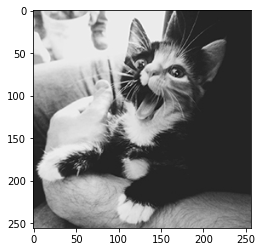

In [49]:
img = rgb2yiq(img)[:,:,0]
plt.imshow (img, 'gray')

## Downsampling

### Downsampling x2

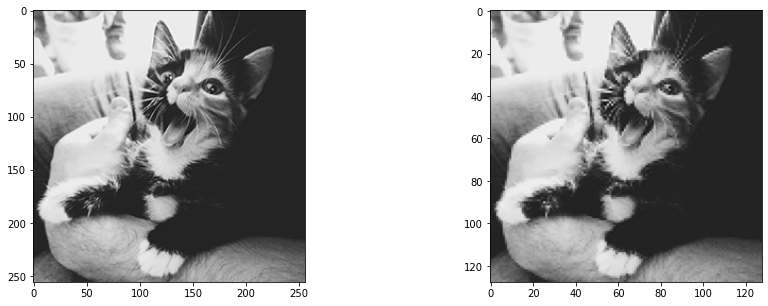

In [50]:
img2 = downsampling(img,2)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img,'gray')
axes[1].imshow(img2,'gray')

### Downsampling promedio

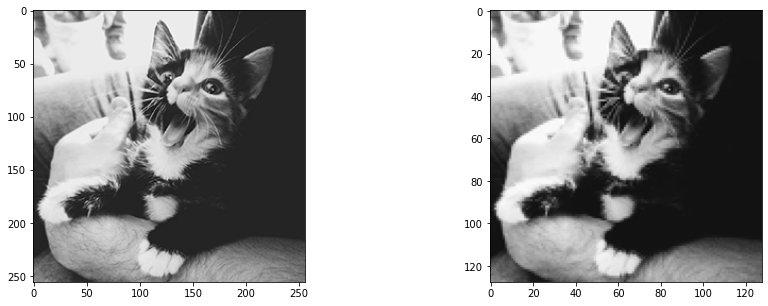

In [51]:
img2 = downsampling_avg(img)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img,'gray')
axes[1].imshow(img2,'gray')


### Filtro gaussiano + sampling cada 2 pixeles

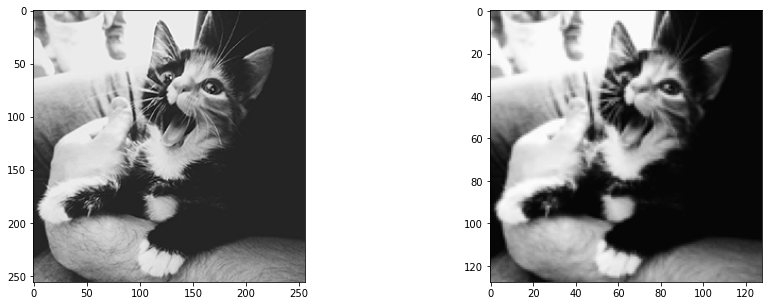

In [52]:
kernel = gaussian(3)
img_filt = convolve2d(img, kernel, mode='same',boundary='symm')

img2 = downsampling(img_filt,2)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img,'gray')
axes[1].imshow(img2,'gray')

### Downsampling usando fft

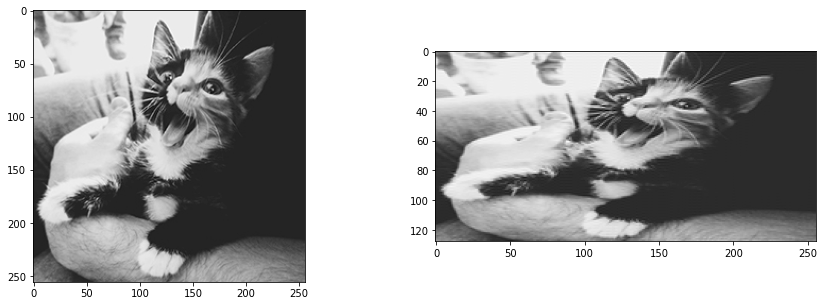

In [64]:
img2 = downsampling_fft(img)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img,'gray')
axes[1].imshow(img2,'gray')

## Upsampling

### Upsampling x2

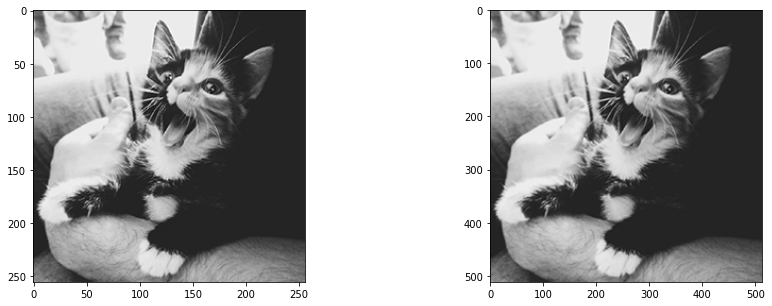

In [53]:
img2 = upsampling_x2(img)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img,'gray')
axes[1].imshow(img2,'gray')

### Interpolación bilineal

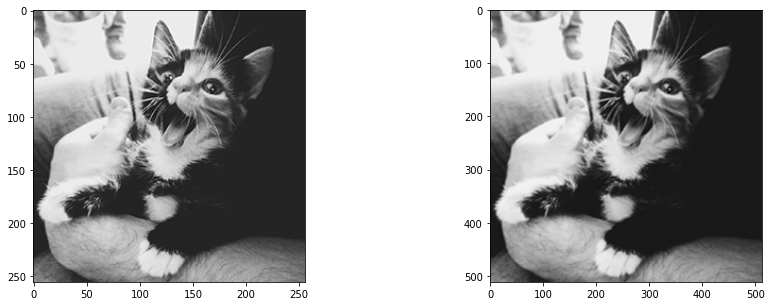

In [54]:
img2 = upsampling_ib(img)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img,'gray')
axes[1].imshow(img2,'gray')

### Interpolación bicúbica

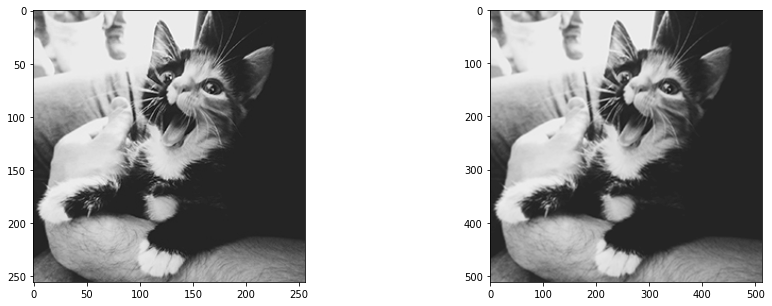

In [55]:
img2 = upsampling_bc(img)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img,'gray')
axes[1].imshow(img2,'gray')

### Repetir pixeles en una grilla de 2x2 y aplicar filtro gaussiano

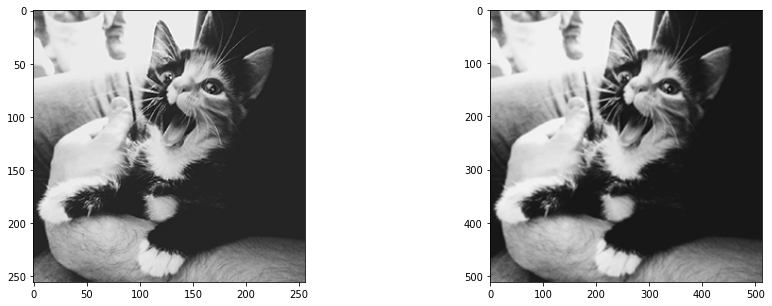

In [56]:
kernel = gaussian(3)
img2 = upsampling_x2(img)
img_filt = convolve2d(img2, kernel, mode='same',boundary='symm')



fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img,'gray')
axes[1].imshow(img_filt,'gray')

### Upsampling usando fft

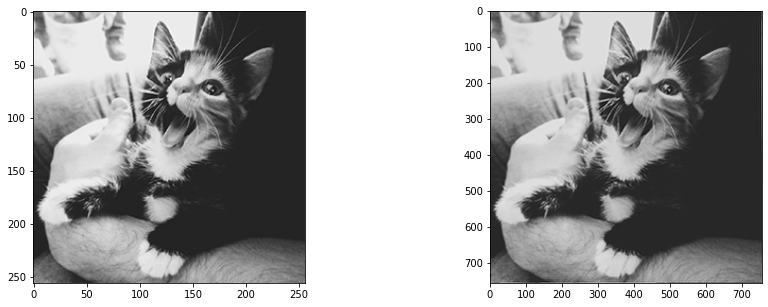

In [69]:
img2 = upsampling_fft(img)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img,'gray')
axes[1].imshow(img2,'gray')

## Cuantizacion

### Cuantizacion Uniforme

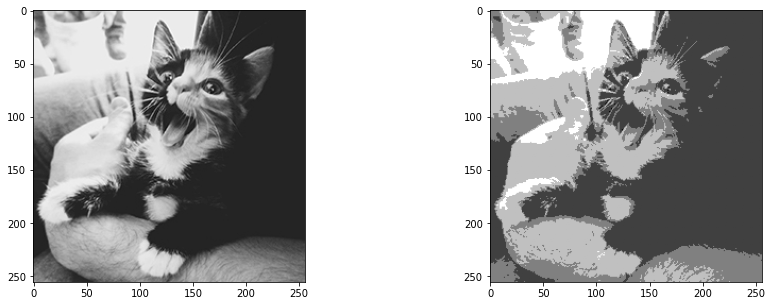

In [72]:
img2 = np.round(img*4)/4

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img,'gray')
axes[1].imshow(img2,'gray')

### Difusión del error por scanline

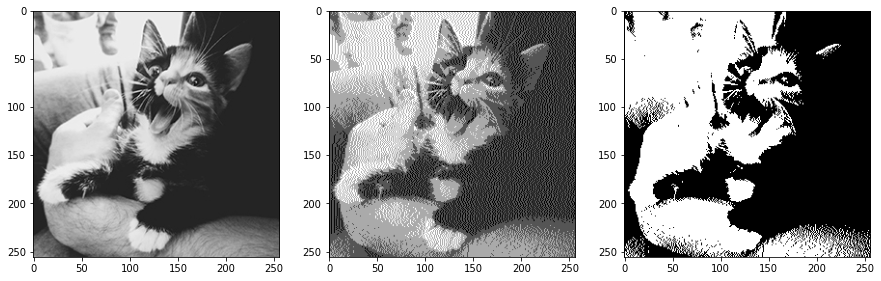

In [87]:
img2 = cuantizacion_scanline(img,4)
img3 = np.round(img2)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(img,'gray')
axes[1].imshow(img2,'gray')
axes[2].imshow(img3, 'gray')

### Dithering de Floyd-Steinberg

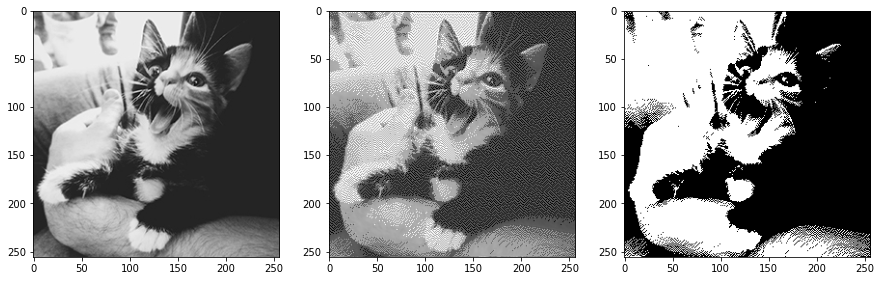

In [94]:
img2 = cuantizacion_fsteinberg(img,4)
img3 = np.round(img2)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(img,'gray')
axes[1].imshow(img2,'gray')
axes[2].imshow(img3, 'gray')